# Testing a model

This notebook loads a trained XGBoost model and the test set and measures the accuracy of the XGBoost model. Predictions on experimental PDFs can also be made here.

**How to use:** Run the cells underneath from top to bottom 

The first cell imports packages and functions from the backend. The next cells loads the PDF dataset and the XGBoost model. Then, the XGBoost model is tested on the PDF test set.
Lastly, an experimental PDF can be loaded and the XGBoost model can predict its structure. The results from the prediction is then saved in the results folder.

# Import packages and functions from backend

In [3]:
import sys, os
import xgboost as xgb

sys.path.append("Backend")

from testing import sort_filenames, get_testing_backend, load_PDFs, test_model, load_exp_pdf, plot_loaded_PDF, model_predict_cluster, fit, fit_top3
sorted_filenames_flat, xyz_path = get_testing_backend(xyz_folder_name = "natoms200")

# Import PDF dataset

Load PDF dataset from the folder "/PDF_datasets/". Specify the folder name of the dataset you want to load and train a model on.

In [2]:
folder_name = "big_seed37"

X_train, y_train, X_val, y_val, X_test, y_test = load_PDFs(folder_name)
display(X_test)

,1,2,3,4,5,6,7,8,9,10,...,294,295,296,297,298,299,300,qmin,qmax,qdamp
0,0.0,-0.006279,-0.015625,-0.020340,-0.029068,-0.037323,-0.043335,-0.054291,-0.060974,-0.070007,...,-0.003462,-0.003090,-0.002642,-0.002132,-0.001640,-0.001066,-0.000515,1.279297,23.968750,0.029556
1,0.0,-0.031281,-0.011749,0.019073,-0.001014,-0.042389,-0.033600,0.005581,-0.003677,-0.051727,...,0.022476,0.027069,0.028198,0.022995,0.019424,0.022308,0.025604,0.226074,14.304688,0.038391
2,0.0,0.076172,0.018524,-0.100037,-0.100708,0.007675,0.032440,-0.082153,-0.164062,-0.096313,...,0.000577,0.006184,0.005898,-0.000683,-0.003550,0.001640,0.005463,1.014648,13.835938,0.015076
3,0.0,-0.008041,-0.008270,-0.015823,-0.025574,-0.026489,-0.033783,-0.046448,-0.048920,-0.055878,...,0.004555,0.004261,0.004646,0.004181,0.003513,0.003656,0.003126,1.349609,20.281250,0.034882
4,0.0,-0.016296,-0.015091,-0.010887,-0.024872,-0.044861,-0.045898,-0.038239,-0.051117,-0.076294,...,0.003857,0.003271,0.003134,0.003275,0.002928,0.002182,0.001812,1.164062,15.242188,0.020859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56140,0.0,-0.001134,0.000018,-0.001935,-0.002291,-0.001367,-0.003641,-0.003220,-0.003189,-0.005386,...,-0.007492,-0.007114,-0.006889,-0.006668,-0.006313,-0.006145,-0.005867,0.105957,22.734375,0.039734
56141,0.0,0.016907,0.002754,-0.004509,0.017365,0.024246,0.002708,0.001069,0.022369,0.015221,...,-0.001592,0.001229,0.001989,0.000394,0.001302,0.003796,0.003279,1.740234,16.875000,0.032776
56142,0.0,-0.017883,0.011421,-0.022247,-0.024475,0.002367,-0.039825,-0.028381,-0.017593,-0.056244,...,0.000207,-0.000507,0.000884,-0.000117,-0.000086,0.000945,-0.000440,0.896484,22.421875,0.039032
56143,0.0,0.001722,0.010262,0.008896,0.011696,0.017853,0.012917,0.015121,0.015335,0.007065,...,0.002895,0.003574,0.004013,0.003670,0.004219,0.003998,0.003387,1.771484,22.687500,0.026184


0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
          ...  
56140    3742.0
56141    3742.0
56142    3742.0
56143    3742.0
56144    3742.0
Name: filename, Length: 56145, dtype: float64

# Load XGBoost model

Specify the name name of the XGBoost model. The same as the folder_name in 2_Training.ipynb.

In [4]:
model_name = "big_seed37" #Big is a model trained on 100 PDFs per cluster with 15 PDFs per cluster in the validation and test set

model_trained = xgb.Booster({'nthread': 4})
model_trained.load_model("Models/XGBmodel_" + model_name + ".model")

# Test XGBoost model on the PDF test set

Tests the XGBoost model on the PDF test set and gives the accuracies in the models best prediction, as well as the models best 3 and best 5 predictions.

In [6]:
test_model(X_test, y_test, model_trained)

y_pred_test:
[0, 0, 1, 2, 2, 3, 4, 4, 128, 6, 6, 7, 8, 8, 9, 10, 10, 11, 12, 12, 13, 162, 14, 15, 16, 16, 17, 18, 18, 19, 20, 20, 19, 22, 22, 23, 24, 24, 25, 26, 26, 252, 28, 28, 29, 30, 30, 31, 32, 32, 237, 34, 34, 35, 36, 36, 37, 38, 38, 39, 40, 40, 259, 42, 42, 43, 44, 44, 45, 46, 46, 47, 48, 48, 49, 50, 50, 51, 52, 761, 53, 54, 54, 55, 56, 273, 57, 58, 58, 59, 60, 60, 61, 156, 316, 63, 64, 64, 65, 66, 66, 67, 68, 68, 132, 70, 70, 71, 72, 72, 73, 74, 74, 75, 76, 76, 77, 78, 78, 79, 80, 80, 81, 82, 82, 83, 84, 84, 85, 86, 86, 87, 88, 88, 89, 90, 138, 91, 92, 92, 93, 94, 94, 95, 327, 96, 97, 299, 98, 99, 100, 100, 101, 102, 102, 103, 104, 104, 105, 106, 106, 56, 108, 108, 109, 229, 110, 194, 112, 112, 113, 114, 266, 115, 116, 116, 117, 118, 118, 119, 120, 120, 121, 122, 122, 123, 124, 124, 125, 126, 126, 127, 128, 128, 129, 130, 130, 131, 132, 132, 133, 134, 134, 135, 136, 136, 137, 138, 138, 139, 140, 140, 141, 142, 142, 143, 144, 144, 145, 146, 146, 147, 148, 148, 149, 150, 150, 151

KeyError: 1

# Load experimental PDF

Shows the PDFs in the folder "ExperimentalData/". Set exp_filename to the desired filename and load the desired experimental PDF.

In [3]:
print(os.listdir("ExperimentalData"))

['Au144PET_100K-00000.gr', 'Au146pMBA.gr', 'Cleaned', 'JQ_S3_Pt_FCC.gr']


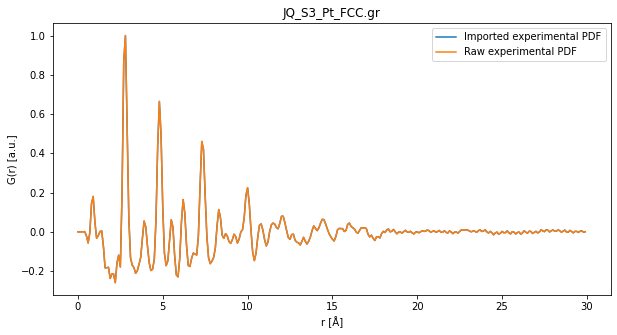

In [7]:
exp_filename = "JQ_S3_Pt_FCC.gr"
xgrid, xyz_pdf, xyz_pdf_raw = load_exp_pdf(exp_filename)
plot_loaded_PDF(xgrid, xyz_pdf, xyz_pdf_raw, exp_filename)

# Predict on experimental PDF with XGBoost model

Predicts the structure of an experimental PDF. The XGBoost model predicts on the PDF as well as the Qmin, Qmax and Qdamp. Therefore, enter these values for your specific experimental PDF in the cell below. The next cell predicts with the XGBoost model, fits simulated PDFs from the top 3 predictions to the experimental PDF, plots it and saves the results and the plot to "Results/"

In [8]:
Qmin = 1.0   #Insert Qmin yourself
Qmax = 22    #Insert Qmax yourself
Qdamp = 0.03 #Insert Qdamp yourself - Standard Qdamp is: 0.03

In [9]:
indexn_list, guess_filenames, top5list = model_predict_cluster(xyz_path, xyz_pdf, exp_filename, model_trained, sorted_filenames_flat, Qmin, Qmax, Qdamp)
fit_top3(guess_filenames, xyz_path, exp_filename, Qmin, Qmax, Qdamp)

The model was given cluster: JQ_S3_Pt_FCC.gr
The model predicts the following:
Prediction 1 with 41.0 % is: FCC_h_4_k_4_l_7_atom_Hg_lc_2.78.xyz
Prediction 2 with 39.2 % is: FCC_h_2_k_4_l_7_atom_Cr_lc_2.38.xyz
Prediction 3 with 4.41 % is: Decahedron_p_3_q_4_r_0_atom_Zn_lc_2.42.xyz
Prediction 4 with 2.69 % is: Decahedron_p_3_q_2_r_0_atom_V_lc_2.44.xyz
Prediction 5 with 1.73 % is: HCP_Size1_3_Size2_4_Size3_7_atom_Re_lc1_2.56_lc2_4.18048.xyz
The five predicted clusters have been saved to Results/JQ_S3_Pt_FCC/

Fit of the first prediction: FCC_h_4_k_4_l_7_atom_Hg_lc_2.78.xyz


Loading BokehJS ...

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       2.54524235
Contributions  2.54524235
Restraints     0.00000000
Chi2           2.54524235
Reduced Chi2   0.00137581
Rw             0.23629938

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Biso       8.21372013e-01 +/- 3.06131760e-01
scale      1.34045741e-01 +/- 3.01769384e-02
zoomscale  9.98318989e-01 +/- 4.62334811e-03

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(scale, Biso)   0.7358

Fit of the second prediction: FCC_h_2_k_4_l_7_atom_Cr_lc_2.38.xyz


Loading BokehJS ...

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       4.50629619
Contributions  4.50629619
Restraints     0.00000000
Chi2           4.50629619
Reduced Chi2   0.00243584
Rw             0.31441835

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Biso       7.77281288e-01 +/- 3.04188909e-01
scale      1.51106497e-01 +/- 3.47193969e-02
zoomscale  1.16624778e+00 +/- 6.04266772e-03

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(scale, Biso)   0.7339

Fit of the third prediction: Decahedron_p_3_q_4_r_0_atom_Zn_lc_2.42.xyz


Loading BokehJS ...

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       9.54585544
Contributions  9.54585544
Restraints     0.00000000
Chi2           9.54585544
Reduced Chi2   0.00515992
Rw             0.45762047

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Biso       6.80908725e-01 +/- 3.07759710e-01
scale      1.42350007e-01 +/- 3.30526099e-02
zoomscale  1.14723690e+00 +/- 8.05098241e-03

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(scale, Biso)   0.6962
